In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.optimize as opt

from datetime import datetime

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

# Loading data

In [3]:
num_runs = 17
data_all = []
path = "Lab2RaspPi/data/14May23/" if os.path.exists("Lab2RaspPi/data/14May23/") else "14May23/"

for i in range(1, num_runs+1):
    if i < 10:
        data_all.append(pd.read_csv(path + f"data0{i}.csv"))
    else:
        data_all.append(pd.read_csv(path + f"data{i}.csv"))

    # Convert time to miliseconds
    data_all[-1]["time_ms"] = data_all[-1]["now"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000)
    data_all[-1]["time_ms"] = data_all[-1]["time_ms"].apply(lambda x: x - data_all[-1]["time_ms"].iloc[0])

    # Remove outliers
    data_all[-1] = data_all[-1][data_all[-1].intensity > 0.65]



In [4]:
# Drop rows with nan
for i in range(num_runs):
    data_all[i] = data_all[i].dropna()

In [5]:
stat_data = data_all[16-1]
cw_data = data_all[15-1]
ccw_data = data_all[12-1]

In [6]:
# Append headers (comment out if headers already added)
header = "now,intensity,humidity,temperature,temperature_from_humidity,temperature_from_pressure,pressure,orientation_roll,orientation_pitch,orientation_yaw,compass,compass_raw_x,compass_raw_y,compass_raw_z,gyro_roll,gyro_pitch,gyro_yaw,gyro_raw_x,gyro_raw_y,gyro_raw_z,accelerometer_raw_x,accelerometer_raw_y,accelerometer_raw_z, accelerometer_roll, accelerometer_pitch, accelerometer_yaw\n"

def append_headers(i_start, i_end):
    for i in range(i_start, i_end):
        if i < 10:
            f = open(f"data0{i}.csv", "r+")
        else:
            f = open(f"data{i}.csv", "r+")
        content = f.read()
        f.seek(0, 0)
        f.write(header + content)
        f.close()

# append_headers(1, 17+1)



# Plotting $I(\Omega(t))$

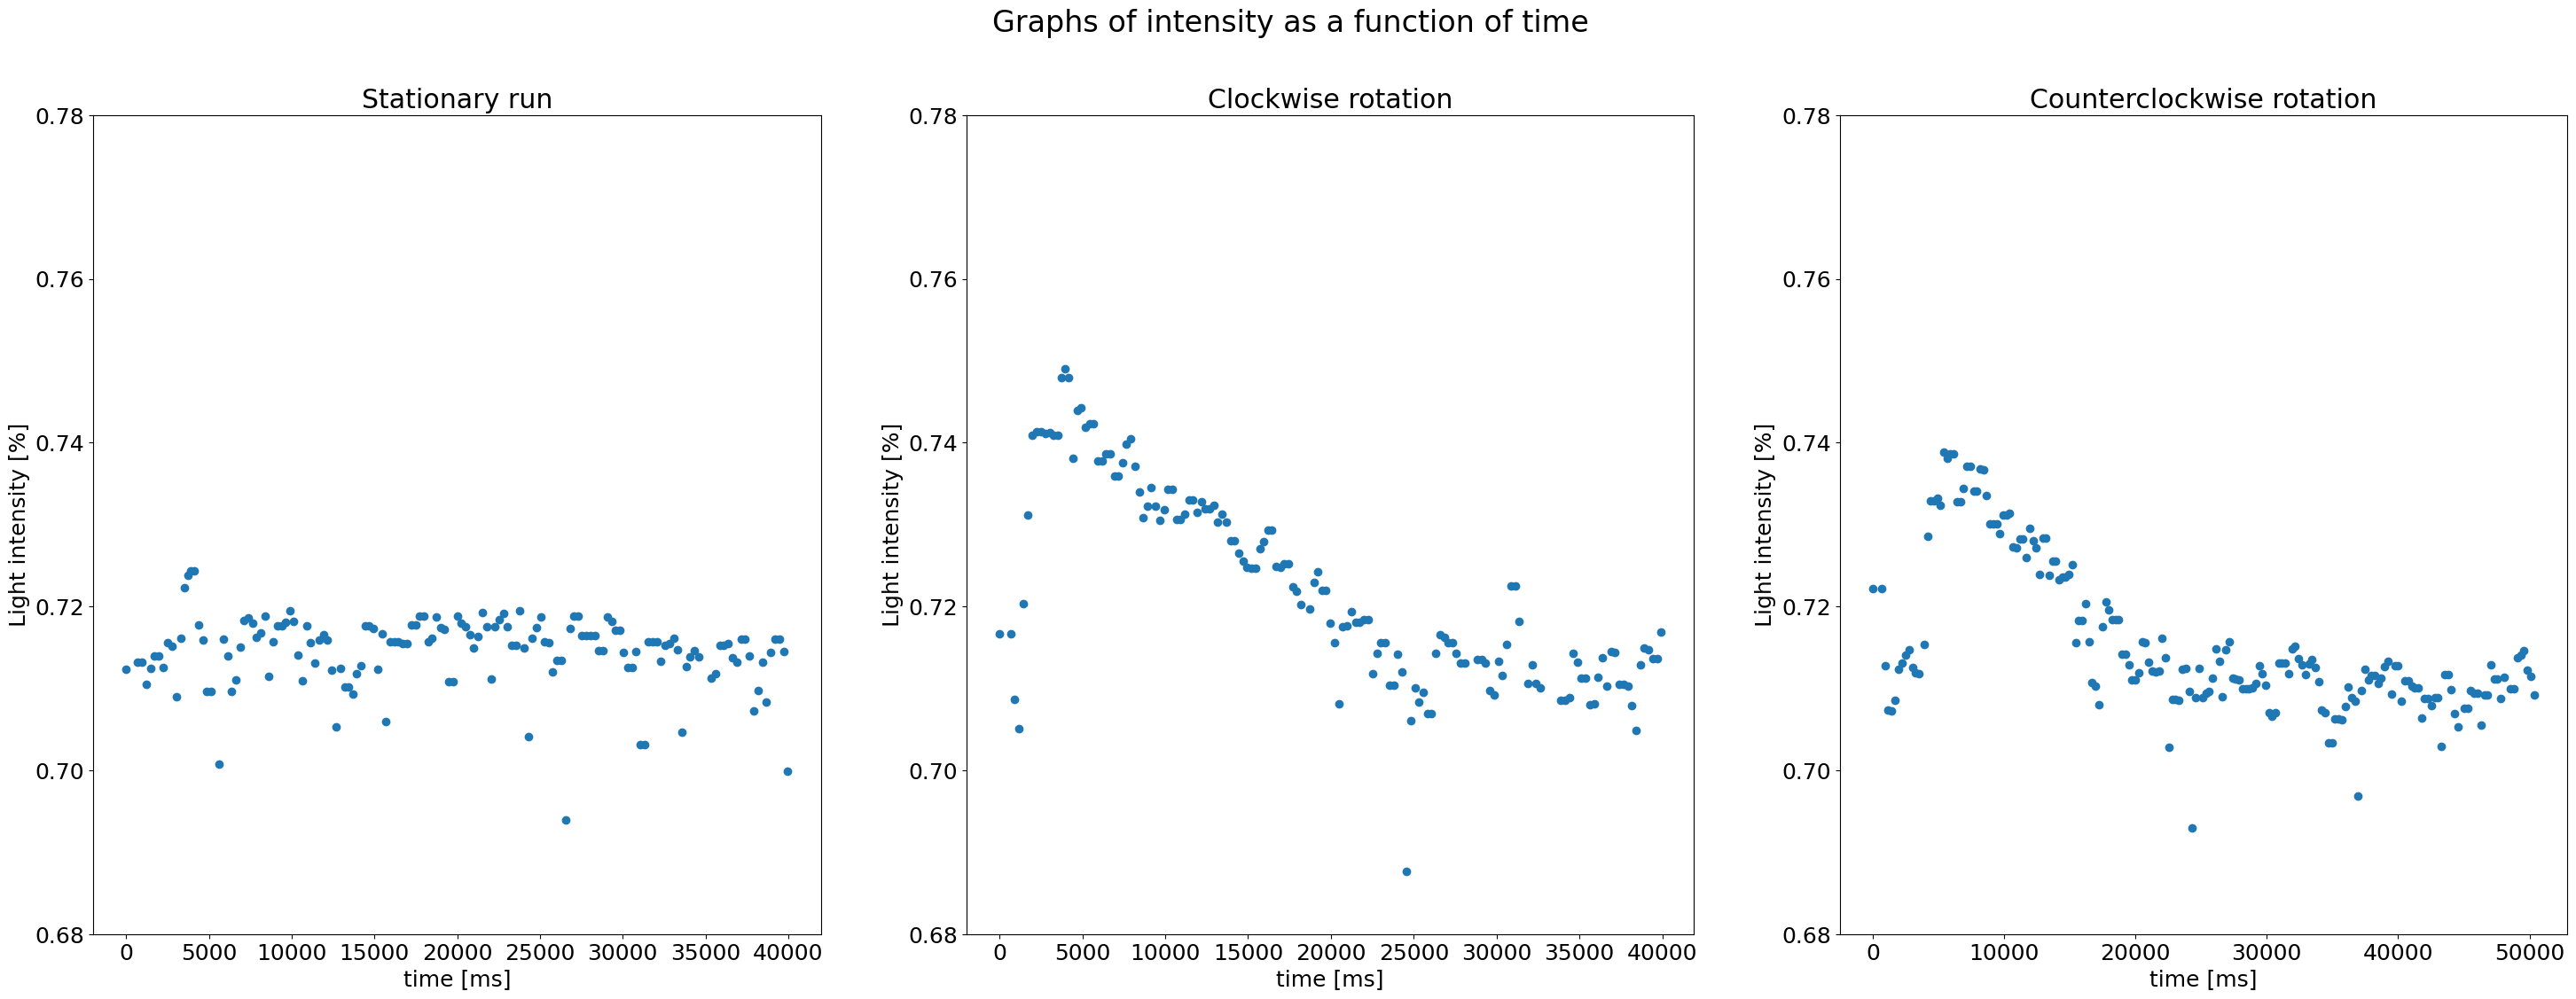

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.suptitle("Graphs of intensity as a function of time", fontsize=24)

for i in range(3):
    ax[i].set_ylim([0.68, 0.78])

ax[0].scatter(stat_data["time_ms"], stat_data["intensity"])
ax[0].title.set_text("Stationary run")
ax[0].set_xlabel("time [ms]")
ax[0].set_ylabel("Light intensity [%]")

ax[1].scatter(cw_data["time_ms"], cw_data["intensity"])
ax[1].title.set_text("Clockwise rotation")
ax[1].set_xlabel("time [ms]")
ax[1].set_ylabel("Light intensity [%]")


ax[2].scatter(ccw_data["time_ms"], ccw_data["intensity"])
ax[2].title.set_text("Counterclockwise rotation")
ax[2].set_xlabel("time [ms]")
ax[2].set_ylabel("Light intensity [%]")

plt.show()

# Plotting true $\Omega(t)$

In [8]:
# a.k.a we plotting d(yaw)/dt
# Take the derivative

for i in range(num_runs):
    data_all[i]["yaw_rad"] = data_all[i]["gyro_yaw"].apply(np.deg2rad)
    data_all[i]["yaw_rad"] = np.unwrap(data_all[i]["yaw_rad"])

    data_all[i]["dt"] = data_all[i]["time_ms"].diff()
    data_all[i]["dYaw"] = data_all[i]["yaw_rad"].diff()

    data_all[i]["Omega"] = 1000 * data_all[i]["dYaw"] / data_all[i]["dt"]

    data_all[i] = data_all[i].dropna()  # Remove nans

stat_data = data_all[16-1]
cw_data = data_all[15-1]
ccw_data = data_all[12-1]

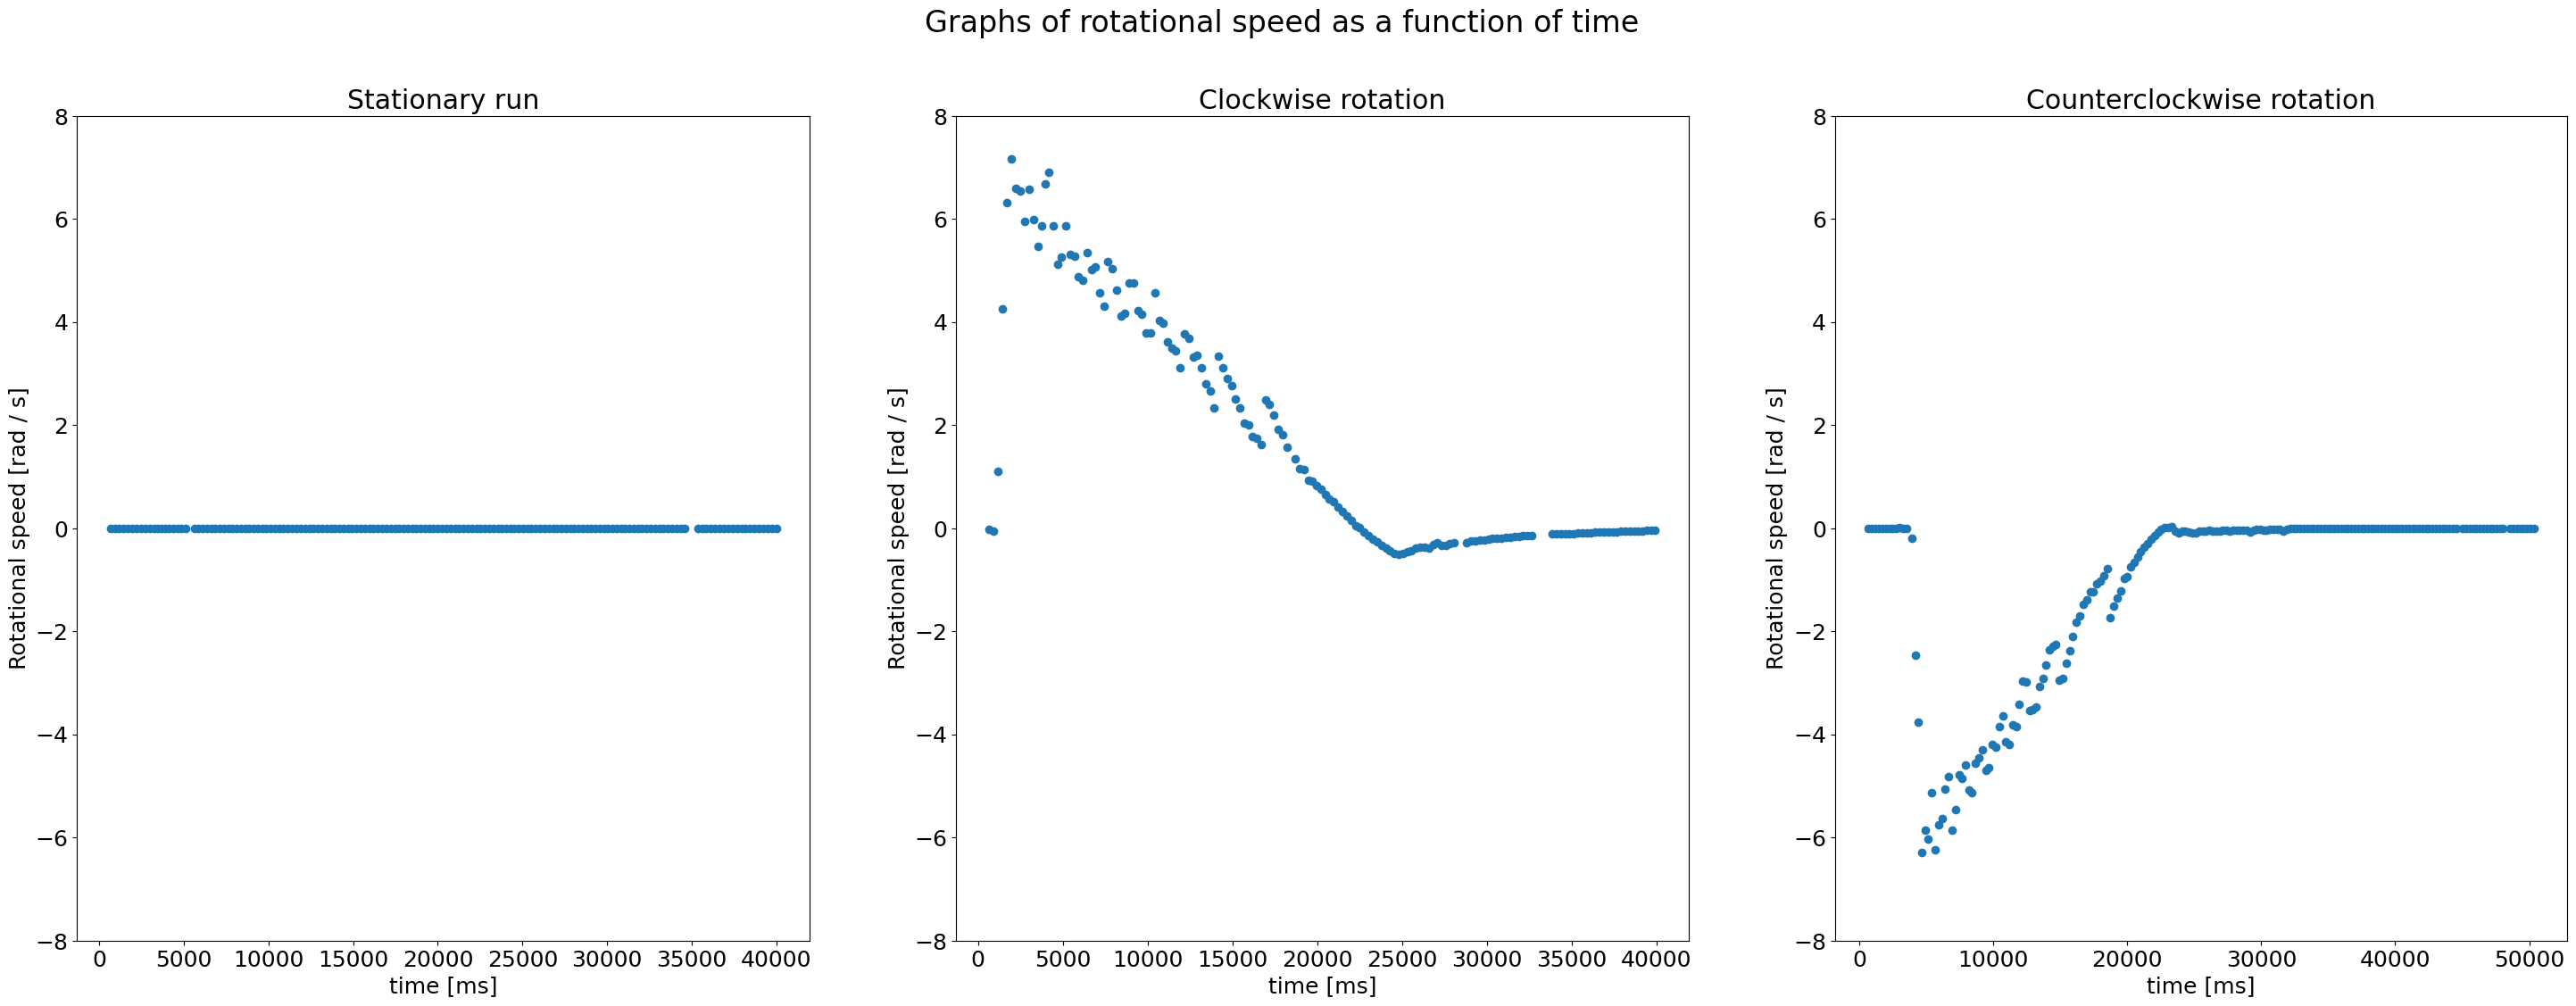

In [9]:
# the actual plotting

fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.suptitle("Graphs of rotational speed as a function of time", fontsize=24)

for i in range(3):
    ax[i].set_ylim([-8, 8])

ax[0].scatter(stat_data["time_ms"], stat_data["Omega"])
ax[0].title.set_text("Stationary run")
ax[0].set_xlabel("time [ms]")
ax[0].set_ylabel("Rotational speed [rad / s]")

ax[1].scatter(cw_data["time_ms"], cw_data["Omega"])
ax[1].title.set_text("Clockwise rotation")
ax[1].set_xlabel("time [ms]")
ax[1].set_ylabel("Rotational speed [rad / s]")

ax[2].scatter(ccw_data["time_ms"], ccw_data["Omega"])
ax[2].title.set_text("Counterclockwise rotation")
ax[2].set_xlabel("time [ms]")
ax[2].set_ylabel("Rotational speed [rad / s]")

plt.show()

#  Calibrate glass setup
Formula $\Phi = 2\pi \frac{LD}{\lambda c} \Omega$, where L is combine length of tubes and D is the diameter od the circle circumsc

In [10]:
# consts
pi = np.pi
R = A = (9.3*12.25) / 10000  # m
c = 299792458  # m / s
lambda_c = 532 * 10**(-9)  # m
L = 4*pi*5.85/100 + 2*(9.3+12.25)/100  # m
D = 15.38/100  # m

In [11]:
def fit_func(x, a, b):
    # return b - a*x
    return b*np.cos(2*pi*L*D*x/(lambda_c * c)+a)

def fit_func_const(x, a):
    return a

In [12]:
calibration_omega = np.array([])
calibration_intensity = np.array([])

for i in [12, 13, 14]:
    calibration_omega = np.append(calibration_omega, np.array(data_all[i]["Omega"]))
    calibration_intensity = np.append(calibration_intensity, np.array(data_all[i]["intensity"]))


In [13]:
# calc fit
popt, pcov = opt.curve_fit(fit_func, calibration_omega, calibration_intensity, bounds=[(-pi, 0), (pi, 1)])
da, db = np.sqrt(np.diag(pcov))
a, b = popt

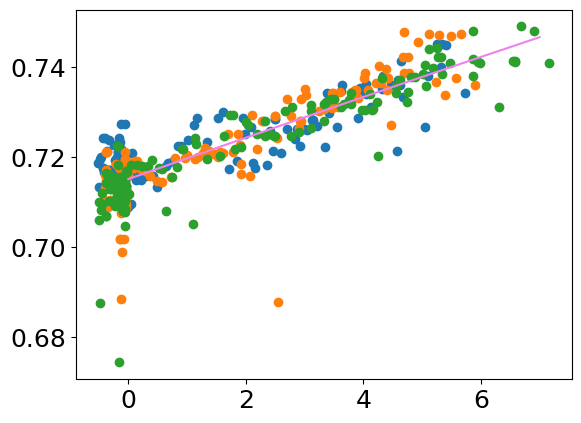

In [14]:
# plot fit
Ierr = 0.002
xs = np.linspace(0, 7, 1000)
for i in [12, 13, 14]:
    plt.errorbar(data_all[i]["Omega"], data_all[i]["intensity"], yerr=Ierr, fmt="o")
plt.title(f"Graph of intensity $I$ as a function of rotational speed $\omega$")
plt.xlabel(f"$\omega$ [rad / s]")
plt.ylabel(f"$I$ [%]")
plt.plot(xs, fit_func(xs, *popt), c="violet")
plt.show()

In [15]:
I0 = b
alpha = a

print(I0*np.cos(alpha))  # sanity check, yaaay

0.7151549932165944


In [16]:
popt, pcov = opt.curve_fit(fit_func_const, np.array(data_all[15]["Omega"]), np.array(data_all[15]["intensity"]))
dIcos = np.sqrt(np.diag(pcov))[0]
Icos = popt[0]

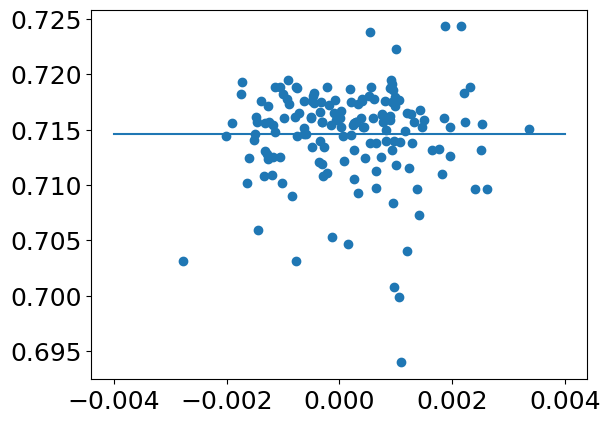

In [17]:
xs = np.linspace(-0.004, 0.004, 1000)
plt.scatter(np.array(data_all[15]["Omega"]), np.array(data_all[15]["intensity"]))
plt.plot(xs, len(xs)*[Icos])
plt.show()

## Calculating rotation speed from intensity

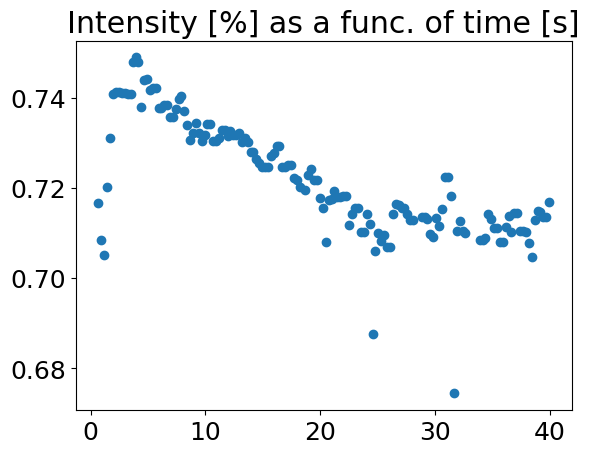

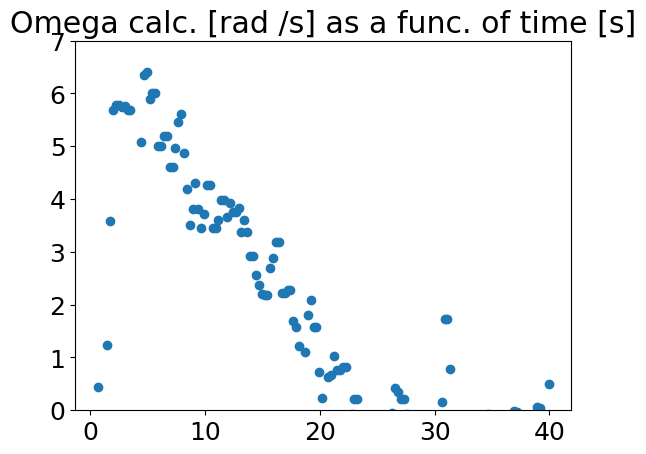

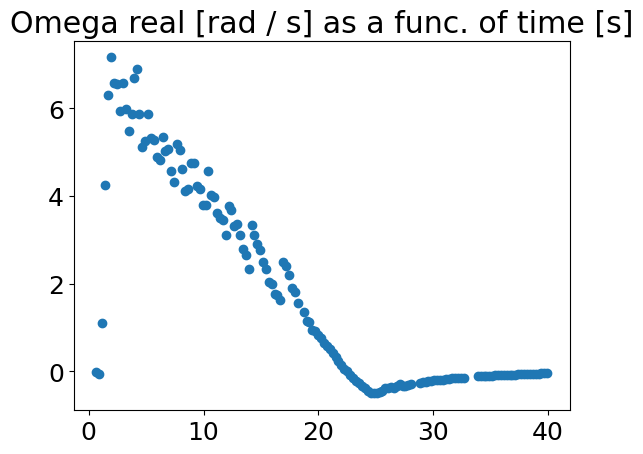

In [18]:
run = 14
test_intensity = np.array(data_all[run]["intensity"])
test_time = np.array(data_all[run]["time_ms"])
test_omega = np.array(data_all[run]["Omega"])

# test_res_phi  = np.arccos(test_intensity / I0) - alpha
# test_res_phi = - (test_intensity - Icos) / (I0*np.sin(alpha))
test_res_phi = (Icos - test_intensity) / (I0*np.sin(alpha))
test_res_omega = lambda_c * c / (2*pi*L*D) * test_res_phi

plt.scatter(test_time/1000, test_intensity)
plt.title("Intensity [%] as a func. of time [s]")
plt.show()

plt.scatter(test_time/1000, test_res_omega)
plt.title("Omega calc. [rad /s] as a func. of time [s]")
plt.ylim((0, 7))
plt.show()

plt.scatter(test_time/1000, test_omega)
plt.title("Omega real [rad / s] as a func. of time [s]")
plt.show()

### THIS IS NOT THE WAY
graph func: $I = I_0 \cos(\Phi +\alpha) \approx I_0 \cos \alpha - (I_0 \sin \alpha) \Phi = I_0 \cos \alpha - \left(I_0 \frac{8 \pi A}{\lambda c} \sin \alpha \right) \Omega$
$a = -I_0 \frac{8 \pi A}{\lambda c} \sin \alpha,~ b = I_0$

In [19]:
a, b = popt
I0cos = b  # Matches stationary runs (sanity check done)
I0sin = -a * lambda_c * c / (8 * pi * A)
I0 = np.sqrt(I0sin**2 + I0cos**2)
alpha = np.arccos(I0cos / I0)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# Test
I0cos = 0.715
I0 = 2*(b - I0cos/2)


I0sin = -a * lambda_c * c / (2*pi*L*D)

I0sin2 = np.sqrt(I0**2 - I0cos**2)